## ASSIGNMENT-3

Student IDs: 

Names: 

### Instructions
 * Fill in the student ID and name of the team members in the cell above.
 * Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
 * You can use the in-built methods and **unless explicitly mentioned**, don't need to code from scratch for this assignment. Make sure your code is modular.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to a straight zero.
 <!-- * Write a report that briefly describes your approach/algorithm used, your final results and any other findings. -->
 <!-- * Add any report, graphs, plots and other results files in the results folder. -->
 * Submit a zip containing this notebook and results folder on Moodle as <team_name\>.zip. 
 * The deadline is **March 25th, 23:55 IST**. This is a hard deadline, and no submissions will be accepted after this.

### SECTION 1: Coding: Sampling based MPC using MPPI update rule

In Model Predictive Controls, we use a simplified model of the vehicle to predict trajectories for H timesteps into the future. Each timesteps are separated by dt time interval. Using a unicycle kinematics model of the vehicle, write a Model Predictive Controller with the goal reaching cost function and the following constraints:

* Velocity bound constraints
* Angular-velocity bound constraints
* Acceleration bound constraints
* Angular acceleration bound constraints
* Lane boundary constraints
* Static obstacle avoidance constraints

#### Assumptions:
* dt = 0.1
* maximum velocity (vmax) = $20 m/s$
* minimum velocity (vmin) = $0 m/s$
* maximum acceleration (amax) = $5 m/s^2$
* minimum acceleration (amin) = $−5 m/s^2$
* maximum angular-velocity (ωmax) = $0.5 rad/s$
* minimum angular-velocity (ωmin) = $−0.5 rad/s$
* maximum angular acceleration (αmax) = $0.1 rad/s^2$
* minimum angular acceleration (αmin) = $−0.1 rad/s^2$
* the agent and the obstacles are represented as circles of radius 2 meters.
* the road is vertical, and the right road boundary is at $x = 6$, and the left road boundary is at  $x = −6$.

#### Deliverables
* Plot the executed velocity, angular velocity, acceleration and angular acceleration curves.

Ensure the code is well written and runs if the values of certain variables are changed. We can ask you to explain certain snippets of it during the evaluations. All the plots and visualizations need to have proper titles. The code should run properly even if the values of any parameters are changed.

The starter code is given below.

In [2]:
from time import time
import casadi as ca
import numpy as np
from casadi import sin, cos, pi
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import os
import copy
np.set_printoptions(suppress=True)
%matplotlib inline

## [Documentation](https://web.casadi.org/docs/#document-functionhttps://web.casadi.org/docs/)

NLP solvers distributed with CASADI solves a non-linear program in the following form:


\begin{split}\begin{array}{cc}
\begin{array}{c}
\text{minimize:} \\
x
\end{array}
&
f(x,p)
\\
\begin{array}{c}
\text{subject to:}
\end{array}
&
\begin{array}{rcl}
  x_{\textrm{lb}} \le &  x   & \le x_{\textrm{ub}} \\
  g_{\textrm{lb}} \le &g(x,p)& \le g_{\textrm{ub}}
\end{array}
\end{array}\end{split}

Here $x$ is the decision variable and $p$ is a known parameter.

# Helper functions

In [3]:
def DM2Arr(dm):
    return np.array(dm.full())

In [4]:
def draw_circle(x, y, radius):
    th = np.arange(0,2*np.pi,0.01)
    xunit = radius * np.cos(th) + x
    yunit = radius * np.sin(th) + y
    return xunit, yunit  

In [5]:
def draw(agent_list):
    for i in range(len(agent_list)):
        a = agent_list[i]
        # print(a.X0)
        x = DM2Arr(a.X0)
        u = DM2Arr(a.u0)
        g_state = a.state_target #DM2Arr(a.state_target)
        if(a.id == 1):
            col = 'g'
            plt.scatter(g_state[0], g_state[1], marker='x', color='r')
            plt.scatter(x[0,1:],x[1,1:], marker='.', color='blue', s=1)            
        else:
            col = 'r'
            plt.scatter(x[0,1:],x[1,1:], marker='.', color=col, s=1)

        x_a, y_a = draw_circle(x[0,1], x[1,1], a.radius) 
        plt.plot(x_a, y_a, col, linewidth=1)


        plt.annotate(str(a.id), xy=(x[0,1]+0.1, x[1,1]+1.2), size=7)
        
        plt.annotate(str(round(u[0,0])), xy=(x[0,1]+0.1, x[1,1]-0.5), size=6)
        

        plt.plot([(x[0,1]), float(g_state[0])], [x[1,1], float(g_state[1])], linestyle='dotted', c='k')

# MPC Class

In [6]:
class Agent:
    def __init__(self, agent_id, i_state, g_state, N=50):
        self.id = agent_id
        self.radius = 2.0
        self.i_state = np.array(i_state) # start state
        self.g_state = np.array(g_state) # goal state
        self.state_init =  copy.deepcopy(self.i_state)  # initial state
        self.state_target = copy.deepcopy(self.g_state) # target state
        
        # state symbolic variables
        self.x = ca.SX.sym('x')
        self.y = ca.SX.sym('y')
        self.theta = ca.SX.sym('theta')
        
        self.states = ca.vertcat(
            self.x,
            self.y,
            self.theta
        )
        self.n_states = self.states.numel()

        # control symbolic variables
        self.v = ca.SX.sym('v')
        self.w = ca.SX.sym('w')
        self.controls = ca.vertcat(
            self.v,
            self.w
        )
        self.n_controls = self.controls.numel()
        
        self.N = N # planning horizon
        
        # control bounds
        self.v_ub = 20
        self.v_lb = 0
        self.w_ub = 0.5
        self.w_lb = -0.5

        # dt
        self.dt = 0.05
        
        # matrix containing all states over all time steps +1 (each column is a state vector)
        self.X = ca.SX.sym('X', self.n_states, self.N + 1)
        # matrix containing all control actions over all time steps (each column is an action vector)
        self.U = ca.SX.sym('U', self.n_controls, self.N)
        # coloumn vector for storing initial state and target state
        self.P = ca.SX.sym('P', self.n_states + self.n_states)
        # state weights matrix (Q_X, Q_Y, Q_THETA)
        self.Q_x = 20
        self.Q_y = 20
        self.Q_theta = 5
        self.Q = ca.diagcat(self.Q_x, self.Q_y, self.Q_theta)

        # Unicycle model
        self.J = ca.vertcat(
            ca.horzcat(cos(self.theta), 0),
            ca.horzcat(sin(self.theta), 0),
            ca.horzcat( 0, 1)
        )
        # RHS = states + J @ controls * self.dt  # Euler discretization
        self.RHS = self.J @ self.controls
        # maps controls from [v, w].T to [vx, vy, omega].T
        self.f = ca.Function('f', [self.states, self.controls], [self.RHS])

        self.OPT_variables = ca.vertcat(
            self.X.reshape((-1, 1)),   # Example: 3x11 ---> 33x1 where 3=states, 11=N+1
            self.U.reshape((-1, 1))
        )

        self.u0 = ca.DM.zeros((self.n_controls, self.N))  # initial control
        self.X0 = ca.repmat(self.state_init, 1, self.N+1)  # initial state full
        self.vl = ca.DM(0) # last velocity
        self.wl = ca.DM(0) # last velocity
        
    def get_goal_cost(self):
        pass
    
    def next_state_constraints(self):
        pass

    def control_bound_constraints(self):
        pass
    
    def obstacle_constraints(self):
        pass

    def lane_boundary_constraints(self):
        pass
    
    def acceleration_constraints(self):
        pass
    
    def angular_acceleration_constraints(self):
        pass
            
    def pred_controls(self):
        pass

## Environment

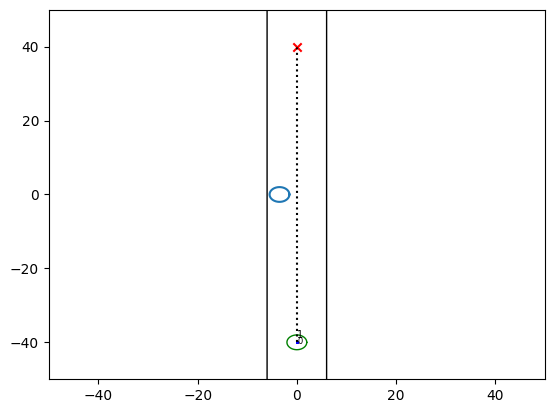

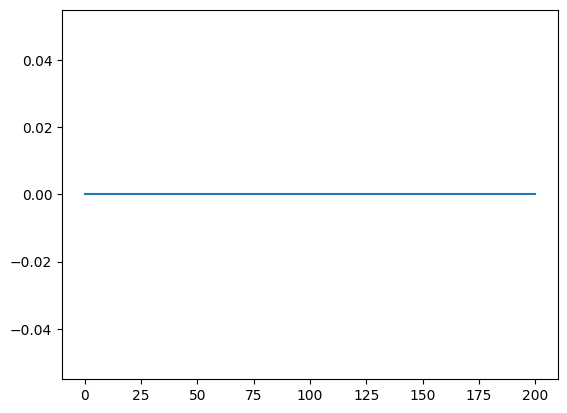

In [7]:
y_lane = np.arange(-1000,1000)
left_lane = -6*np.ones(y_lane.shape)
right_lane = 6*np.ones(y_lane.shape)

a = Agent(1, [0, -40, np.deg2rad(90)],[0,40,np.deg2rad(90)], 30)
obs = [-3.5,0]
draw_list = [a]
timeout = 10
update_y = 0
y_l_lim = -10
y_u_lim = 40
timeout = 10
v_a = []
v_a.append(a.vl.full()[0,0])
while( (ca.norm_2(a.state_init - a.state_target)>=1) and timeout >0):
    
    clear_output(wait=True)
    timeout = timeout - a.dt
    a.pred_controls()
    a.vl = a.u0[0,0]
    a.wl = a.u0[1,0]
    a.state_init = a.X0[:,1]
    v_a.append(a.vl.full()[0,0])
    draw(draw_list)   
    obs_x, obs_y = draw_circle(obs[0], obs[1], 2)
    plt.plot(obs_x, obs_y)
    plt.plot(left_lane,y_lane, 'k', linewidth=1)
    plt.plot(right_lane, y_lane, 'k', linewidth=1)
    plt.xlim([-50, 50])
    plt.ylim([-50, 50])
    plt.show()
    plt.pause(1e-10)
plt.plot(v_a)

## Show the velocity, angular-velocity, acceleration and angular-acceleration plots